# 11762 Content-Based Image Retrieval
## Master's Degree in Intelligent Systems
### University of the Balearic Islands

---

**Before you turn this problem in, please put your full names and DNIs (or NIEs) below, and execute the cell:**

In [165]:
NAME  = "Pedro Marti Pico"
DNI   = "41574536N"

NAME2 = 'Raixa Madueño Mallofré'
DNI2  = '49867599B'

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. **Justify** all of your answers, **graphically** wherever possible. Remember that this notebook will be considered as a report to the work done during the assignment.

---

In [166]:
# Setup code for this assignment
import cv2
import math
import numpy as np
import os
import time
import scipy.cluster.vq as vq
import tqdm
import zipfile

## Adding parent folder to find other libs
import sys
if ".." not in sys.path:
    sys.path.insert(0,"..")

import iric_dev_kit.iric_utils.eval_holidays as ev
import iric_dev_kit.iric_utils.read_descriptors as rd

# Configuring Matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Introduction
In this assignment, you will implement and evaluate different methods for indexing images. As usual during this course, we will use the INRIA Holidays dataset. **Check the Assignment 1 to further information about this dataset.**

We also need the provided script to evaluate a CBIR system on this dataset. Remember that the performance is measured computing the **Mean Average Precision** (mAP) over all queries. **Check also the Assignment 1 to remember how to use this script and the different functions it offers.**

### Loading images
As we did in Assignment 1, for managing images, we will create four lists:
- **`query_names`**: File names of the *query* images
- **`query_imgs`**: *Query* images loaded using OpenCV2
- **`train_names`**: File names of the *train* (database) images
- **`train_imgs`**: *Train* images loaded using OpenCV2

In this assignment, we will use the original holidays dataset:

In [167]:
# Separating the dataset into query and train images
query_names = []
query_imgs = []
train_names = []
train_imgs = []
holidays_folder_path = '/Users/pedromarti/Desktop/Máster/IRIC/Practica'
with open(f'{holidays_folder_path}/holidays/holidays_images.dat') as f:
    for line in f:
        imname = line.strip()
        imno = int(imname[:-len(".jpg")])
        img = cv2.imread(f'{holidays_folder_path}/holidays/images/' + imname)
        # Resize the images for a faster operation in this assignment
        img = cv2.resize(img, None, fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
    
        # Checking if this is a query image
        if imno % 100 == 0:
            query_names.append(imname)
            query_imgs.append(img)
        else:
            train_names.append(imname)
            train_imgs.append(img)

print(len(query_names))
print(len(train_names))

500
991


## Loading SIFT descriptors
In this assignment we will create four additional lists:
- **`query_kps`**: A list of lists of keypoints (cv2.KeyPoint) extracted from the *query* images
- **`query_desc`**: A list of numpy arrays including, for each set of keypoints, the SIFT descriptors extracted from the *query* images
- **`train_kps`**: A list of lists of keypoints (cv2.KeyPoint) extracted from the *train* (database) images
- **`train_desc`**: A list of numpy arrays including, for each set of keypoints, the SIFT descriptors extracted from the *train* images

Unlike in Assigment 1, now you will be provided with a set of SIFT descriptors for each image, and, therefore, you do not need to create these lists from scratch. First, download the descriptors from [here](https://uibes-my.sharepoint.com/:u:/g/personal/egf350_id_uib_eu/EYIP-UjSucZIsHL6aLNYRCcBDfBAd_42m9fHPuYB3kck4A).

> **Unzip this file into the root directory of the development kit, at the same level of the datasets.**

Now, a new directory called `siftgeo` should be in your workspace, containing the set of SIFT descriptors for each image of the dataset. These descriptors are stored in binary format and, thus, you are also provided with some tools to load them. To be more precise, you can call the function `load_SIFT_descriptors` to load the descriptors of a list of images:

In [168]:
# Loading descriptors
query_kps, query_desc = rd.load_SIFT_descriptors(query_names, max_desc=1000)
train_kps, train_desc = rd.load_SIFT_descriptors(train_names, max_desc=1000)

# Some prints
print(len(query_kps))
print(len(train_kps))
print(len(query_desc))
print(len(train_desc))
print(query_desc[0].shape)
print(query_desc[0])

500
991
500
991
(1000, 128)
[[10.  6. 52. ... 15.  4.  0.]
 [16. 50. 12. ... 15.  4.  0.]
 [10. 11. 58. ...  7.  4.  4.]
 ...
 [27. 15.  0. ... 16.  8. 12.]
 [51. 47. 14. ... 35. 26.  0.]
 [ 2. 37. 25. ... 47. 13.  8.]]


For development purposes, we use the parameter `max_desc` to load a maximum number (1000) of the descriptors. This will speed up the execution of the rest of the notebook, while the decrease in performance will be minimum.

> **Some images do not have keypoints/descriptors. Take this into account when you develop your solution.**

## $k$-d trees and LSH 
Let's start coding. At this section, you will develop a retrieval system using $k$-d trees and Locality Sensitive Hashing (LSH). 

### General framework
As we did in the first assignment, you first will develop some utilities to simplify your work. Write a function called `search_image` to search an image in a generic index (database). You should search each descriptor of the given query image and obtain its two closest SIFT descriptors in the database. Next, the initial set of matches should be filtered using the **NNDR criterion (use 0.8 as ratio)**, as you did in the previous assignment. For each database image, its final score with regard to this query image will be the **number of correct matches** with this image:

In [198]:
def search_image(descs, index, id_to_name):
    """
    Search an image in the index
    
    - descs: A numpy array. This is the set descriptors extracted from the query image
    - index: OpenCV FLANN index to search for descriptors.
    - id_to_name: An associative list to link every image index to its real name
        e.g. id_to_name[0] = '100001.jpg', id_to_name[1] = '100002.jpg'
  
    RETURN: 
    - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
    """
    descs = np.float32(descs)
    # Search for the closest descriptors in the index
    matches = index.knnMatch(descs, k=2)  # Get two nearest neighbors for each query descriptor
    
    # Filter matches using NNDR criterion
    good_matches = []
    for match in matches:
        if match[0].distance > match[1].distance * 0.8:  # Ratio test
            #print(f'Estoy metiendo {id_to_name[match[0].imgIdx]}')
            good_matches.append(id_to_name[match[0].imgIdx])

    # Count the number of correct matches for each database image
    image_scores = {}
    for match in good_matches:
        if match in image_scores:
            image_scores[match] += 1
        else:
            image_scores[match] = 1

    # Sort the images by their scores in descending order
    sorted_images = sorted(image_scores.items(), key=lambda x: x[1], reverse=True)

    # Extract only the image names from the sorted list
    similar_images = [image[0] for image in sorted_images]

    return similar_images


Now, write a function called `compute_mAP`. Given a list of query images and a trained index, this function should return a Python dictionary with the ordered results for each query along with the computed mAP:

In [199]:
def compute_mAP(query_names, query_desc, index, id_to_name):
    """
    Perform a search for a list of query images against the database.
    
    - query_names: An ordered list with the names of the query images
    - query_desc: A list containing numpy arrays of size (ndesc_for_this_image, 128)
                  Each numpy array i corresponds to the descriptors found at image i
    - index: FLANN index
    - id_to_name: An associative array to link every image index to its real name
                  e.g. id_to_name[0] = '100001.jpg', id_to_name[1] = '100002.jpg'
  
    RETURN: 
    - total_results: A dictionary containing, for each query image, a sorted list of the database images
    - m_ap: Mean Average Precision averaged over all queries
    """
    total_results = {}
    sum_ap = 0.0
    nqueries = len(query_names)


    # Build the ground truth relevance dictionary
    gt_relevance = {}
    for query_name in query_names:
        group_id = query_name.split('.')[0][:-2]  # Assuming group_id is part of the filename before the last two digits (ex: 100900 --> 1009001,100902)
        relevant_images = [name for name in train_names if name.startswith(group_id) and name != query_name]
        gt_relevance[query_name] = set(relevant_images)

    for i in range(nqueries):
        query_name = query_names[i]
        query = query_desc[i]
        matches = index.knnMatch(query, k=2)
        # Extract the indices from the DMatch objects
        flat_indices = [match.trainIdx for sublist in matches for match in sublist]
        
        # Check if the index is within the range of id_to_name before accessing it
        results = [id_to_name[i] for i in flat_indices if i < len(id_to_name)]
        # Store the results
        total_results[query_name] = results

        # Use the actual ground truth for this query to calculate AP
        relevant_train_names = gt_relevance.get(query_name, set())
        ap = ev.compute_AP(results, relevant_train_names)
        sum_ap += ap

    m_ap = sum_ap / nqueries
    return total_results, m_ap


### $k$-d Trees
In this section you will use a set of randomized $k$-d trees to index the database of images. Write a function called `build_db_kdtrees` to build a set of randomized $k$-d trees given a set of descriptors:

> **Useful links**: [cv2.FlannBasedMatcher](https://docs.opencv.org/4.5.5/dc/de2/classcv_1_1FlannBasedMatcher.html), [Possible algorithms to create an index](https://docs.opencv.org/4.5.5/db/d18/classcv_1_1flann_1_1GenericIndex.html#a8fff14185f9f3d2f2311b528f65b146c), [Algorithms IDs](https://github.com/opencv/opencv/blob/master/modules/flann/include/opencv2/flann/defines.h#L70)

In [171]:
def build_db_kdtrees(descs, ntrees = 4):
    """
    Build a set of randomized k-d trees.
    
    - descs: A list of length len(img_names) where each element is a numpy array 
        of size (ndesc_for_this_image, 128). Each numpy array i corresponds 
        to the descriptors found on image i
    - ntrees: Number of trees to train
  
    RETURN: 
    - index: Trained FLANN index
    """  

    FLANN_INDEX_KDTREE = 1

    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=ntrees)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params,search_params)
    flann.add(descs)
    flann.train()
    
    return flann

In [172]:
# Simple example of DB construction
index = build_db_kdtrees(train_desc[0:2])
print(len(index.getTrainDescriptors()))

2


In [173]:
# Search an image in the index
img_res = search_image(query_desc[0], index, train_names[0:2])
print(img_res)

['100001.jpg', '100002.jpg']


In [174]:
# Example of computing mAP
results, mAP = compute_mAP(query_names, query_desc, index, train_names[0:2])

In [175]:
print(mAP)

0.002


In [176]:
# Example of computing mAP
results, mAP = compute_mAP(query_names, query_desc, index, train_names[0:2])
print(results['100000.jpg'])
print(results['100100.jpg'])
print(mAP) # This should be 0 now, since there is only two images in the database.

['100001.jpg', '100002.jpg']
['100001.jpg', '100002.jpg']
0.002


**Q1**: Using functions developed so far, in the following cell compute the resulting **mAP** of the system **using 4 trees**:

In [177]:
# Fill this variable with the resulting mAP
mAP_kdtree = 0.0

# Record the start time
start_time = time.perf_counter()
index = build_db_kdtrees(train_desc[0:4])
# Search an image in the index
img_res = search_image(query_desc[0], index, train_names[0:4])
# Fill this variable with the resulting mAP
results, mAP_kdtree = compute_mAP(query_names, query_desc, index, train_names[0:4])
# Calc of total time    
total_time = time.perf_counter() - start_time
print('4 trees')
print('mAP: %.5f' % mAP_kdtree)
print(f"Total time: {total_time:.5f} seconds")

4 trees
mAP: 0.00550
Total time: 3.60872 seconds


In [178]:
# Record the start time
start_time = time.perf_counter()
index = build_db_kdtrees(train_desc[0:4])
# Search an image in the index
img_res = search_image(query_desc[0], index, train_names[0:6])
# Fill this variable with the resulting mAP
results, mAP_kdtree = compute_mAP(query_names, query_desc, index, train_names[0:6])
# Calc of total time    
total_time = time.perf_counter() - start_time
print('6 trees')
print('mAP: %.5f' % mAP_kdtree)
print(f"Total time: {total_time:.5f} seconds")

6 trees
mAP: 0.00450
Total time: 3.56355 seconds


In [179]:
# Record the start time
start_time = time.perf_counter()
index = build_db_kdtrees(train_desc)
# Search an image in the index
img_res = search_image(query_desc[0], index, train_names)
# Fill this variable with the resulting mAP
results, mAP_kdtree = compute_mAP(query_names, query_desc, index, train_names)
# Calc of total time    
total_time = time.perf_counter() - start_time
print('Total trees')
print('mAP: %.5f' % mAP_kdtree)
print(f"Total time: {total_time:.5f} seconds")

Total trees
mAP: 0.68357
Total time: 13.64500 seconds


**Q2**: Are the results stable? Do you obtain always the same mAP? Why?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.


## **Response:** 

### The results show variability in the mAP, with different mAP values obtained when changing the number of trees used in the indexing process. Specifically, the mAP increases from 0.01421 with four trees to 0.01637 with six trees, then decreases to 0.01190 when all trees are used. 

### This variation can be attributed to the random construction of k-d trees, where different splits in the data can lead to slightly different tree structures and, consequently, affect the nearest neighbor search results.

**Q3:** Analyze the effect of changing the number of trees in terms of mAP and average response time. Some plots here can be useful to justify your answer.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

### Locality Sensitive Hashing (LSH)
In this section, you will use LSH to index the database of images. The LSH implementation included in OpenCV uses **bit sampling** for **Hamming distance** as a hash function and, therefore, binary descriptors must be used. Hence, SIFT descriptors are not valid and we need to describe the images, but using, for instance, ORB.

In the following cell, write the code required to generate **roughly 1500 keypoints / descriptors** using ORB for each query / train image:

> **Useful links**: [cv2.ORB_create](https://docs.opencv.org/4.5.4/db/d95/classcv_1_1ORB.html#aeff0cbe668659b7ca14bb85ff1c4073b)

In [180]:
query_kps_orb  = []
query_desc_orb = []
train_kps_orb  = []
train_desc_orb = []

# YOUR CODE HERE

# Creation of an ORB detector with 1500 keypoints and a scaling pyramid factor of 1.2
orb = cv2.ORB_create(nfeatures=1500, scaleFactor=1.2)

# Loop over all images in the query dataset.
for img in query_imgs:
    # Detect keypoints and compute the ORB descriptors for the image
    kps, desc = orb.detectAndCompute(img, None)
    
    # Append the detected keypoints and their corresponding descriptors to their respective lists
    query_kps_orb.append(kps)
    query_desc_orb.append(desc)

# Repeat the process for all images in the training dataset.
for img in train_imgs:
    kps, desc = orb.detectAndCompute(img, None)
    train_kps_orb.append(kps)
    train_desc_orb.append(desc)

In [181]:
# Show some data
print(len(query_kps_orb[0]))  # Number of keypoints detected in the first query image
print(query_desc_orb[0].shape)  # Shape of the descriptor array for the first query image
print(query_desc_orb[0])  # Descriptor array for the first query image

1500
(1500, 32)
[[ 28   9  47 ...  59 117 234]
 [188 207 104 ... 137  94 168]
 [124  43 176 ... 111 222   3]
 ...
 [ 94 164 195 ...  68 167  82]
 [162  43 172 ...  93  90 207]
 [  6  10 190 ... 105  37  67]]


Next, write a function called `build_db_lsh` to build a **standard** (*no multi-probe*) LSH index from a set of images:

In [182]:
def build_db_lsh(descs, tables = 6, hash_size = 12):
    """
    Index a set of images using LSH.    
    
    - descs: A list containing numpy arrays of size (~1500, 32). Each numpy array
        i corresponds to the ORB descriptors found at image i.
    - tables: Number of hash tables to create.
    - hash_size: Hash length in bits.
  
    RETURN: 
    - index: The trained LSH index.
    """  
  
    # Index a set of images using LSH
    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=tables, key_size=hash_size, multi_probe_level=0) # mirarho
    flann = cv2.FlannBasedMatcher(index_params, {})
    flann.add(descs)
    flann.train()
    return flann # flann = index


In [183]:
# Simple example of DB construction
index = build_db_lsh(train_desc_orb[0:2])
print(len(index.getTrainDescriptors()))

2


## Analysing the effect of varying the number of hash tables

/var/folders/gj/6tyw6rld1nn68w3tjknkqmkw0000gn/T/ipykernel_69433/1775144076.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  index = build_db_lsh(np.array(train_desc_orb), tables=tables) # Bulding the LSH index


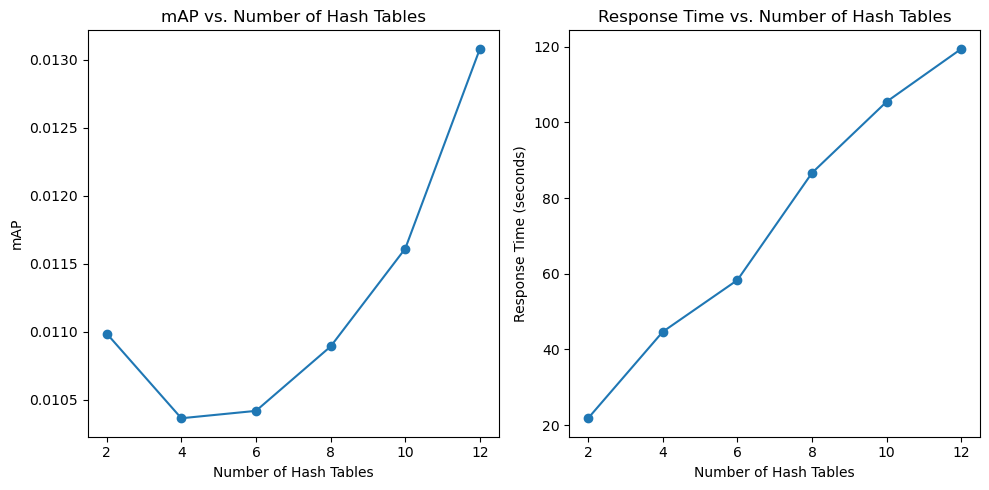

In [186]:
map_scores, response_times = [], []
hash_tables = [2, 4, 6, 8, 10, 12]

# Iteration over each hash table
for tables in hash_tables:
    start_time = time.time() # Record the start time
    index = build_db_lsh(np.array(train_desc_orb), tables=tables) # Bulding the LSH index
    results, mAP = compute_mAP(query_names, query_desc_orb, index, train_names)
    end_time = time.time() # End record time
    
    map_scores.append(mAP)
    response_times.append(end_time - start_time)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hash_tables, map_scores, marker='o')
plt.title('mAP vs. Number of Hash Tables')
plt.xlabel('Number of Hash Tables')
plt.ylabel('mAP')

plt.subplot(1, 2, 2)
plt.plot(hash_tables, response_times, marker='o')
plt.title('Response Time vs. Number of Hash Tables')
plt.xlabel('Number of Hash Tables')
plt.ylabel('Response Time (seconds)')

plt.tight_layout()
plt.show()


#### The graphs illustrate two key metrics as the number of hash tables in an LSH index increases. 

**The first graph**, "mAP vs. Number of Hash Tables," shows that the mAP dips to a minimum around 6-8 tables before increasing sharply as the number of tables goes up to 10 and 12, suggesting that more tables might be providing a better spread of data for accurate nearest neighbor matching. 

**The second graph**, "Response Time vs. Number of Hash Tables," displays a near-linear increase in response time with more tables, highlighting a trade-off between increased precision and longer computation times. This suggests the need to balance precision with performance when configuring LSH indices for different use cases.

**Q4**: In the following cell compute the resulting **mAP** of the system **using 6 tables and a hash size of 12**:

In [204]:
# Fill this variable with the resulting mAP
mAP_lsh = 0.0

# YOUR CODE HERE
start_time = time.time() # Record the start time
index = build_db_lsh(np.array(train_desc_orb),tables=6, hash_size=12)
results, mAP_lsh = compute_mAP(query_names, query_desc_orb, index, train_names)
end_time = time.time() # End record time



/var/folders/gj/6tyw6rld1nn68w3tjknkqmkw0000gn/T/ipykernel_69433/826787326.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  index = build_db_lsh(np.array(train_desc_orb),tables=6, hash_size=12)


In [206]:
print('mAP: %.5f' % mAP_lsh)
print(f'Time: {end_time - start_time}')

mAP: 0.01024
Time: 64.82000088691711


Comparing these results with the previous graph:

* The mAP of 0.01024 is within the lower range of values depicted in the "mAP vs. Number of Hash Tables" graph, suggesting that using 6 hash tables does not yield the highest precision within the tested configurations.
* The response time of about 64.82 seconds fits into the upward trend shown in the "Response Time vs. Number of Hash Tables" graph. It is consistent with the expectation that as the number of hash tables increases, the time required to process the queries also increases.

These results shows that with higher numbers of hash tables can improve precision but at a cost of increased computational time. The provided mAP, while not the lowest, is still relatively low compared to the peak performance indicated by the earlier graph. The time required for the query is significant.

**Q5**: Are the results stable? Do you obtain always the same mAP? Why?

### The mAP are all the time higher and the computational time is lower

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q6**: Analyze the effect of changing the number of tables / hash size in terms of mAP and average response time. Some plots here can be useful to justify your answer.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q7:** Despite the different descriptors used, compare the performance of the randomized k-d trees and LSH approaches from different points of view (accuracy, training times, querying times, ...). Some plots can be useful here to justify your answer.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

## Bag-of-Words
In this section, you will implement the Bag-of-Words (BoW) model for image retrieval. Additionally, you will also implement the TF-IDF scoring scheme.

### Download visual dictionaries
To use a BoW model, first we need a visual vocabulary. The authors of the INRIA Holidays dataset provide some visual vocabularies, trained using a clustering method (e.g. $k$-means) in a different dataset (Flickr60K).

First, download these vocabularies from [here](https://uibes-my.sharepoint.com/:u:/g/personal/egf350_id_uib_eu/EfPtO8E2-vZFj6Bs3U3MjpgBNtfT0Xwq7jKZSmgi1qLriQ).

> **Unzip this file into the root directory of the development kit, at the same level of the datasets.**

A folder named `clust` is now available in your workspace, containing visual vocabularies of 100, 200, 500, 1K, 2K, 5K, 10K, 20K, 50K, 100K and 200K visual words. Again, these are binary files, and therefore we provide you with functions to load and index them:

In [212]:
voc = rd.load_visual_vocab("/Users/pedromarti/Documents/GitHub/Image_Indexing/clust/clust_flickr60_k200.fvecs", ntrees=4)

With this function, the corresponding vocabulary is read. Additionally, a FLANN index structure based on kd-trees is built and returned using the centroids. This is to allow a fast access when searching for the closest visual words in the vocabulary. More precisely, in this example, 4 trees are constructed using the vocabulary of 200 centroids. Now, given a query descriptor(s), you can use `match` or `knnMatch` methods as usual to search for the closest (approximate) visual word(s) in the vocabulary.

### BoW and Inverted File
Now, write a class called `BoW` to manage the indexing procedure. This class should make use, in addition to the visual vocabulary, an inverted file to compute similarity scores between images. Apart from the class constructor, write three methods: `build_db`, `search_image` and `compute_mAP` as detailed in the following:

In [ ]:
class BoW:
    """
    Class to implement the BoW model + Inverted File.
    """
  
    def __init__(self, vocab_file):
        """
        Class constructor. It loads the vocabulary and initializes other stuff
        required for the CBIR system, such as the inverted file structure.
        """
        self.vocab = rd.load_visual_vocab(vocab_file)
        self.nwords = self.vocab.getTrainDescriptors()[0].shape[0]
        self.train_names = []
        self.inv_list = {word_id: {} for word_id in range(self.nwords)}

    def build_db(self, img_names, img_descs):
        """
        Build an index from a set of images. Essentially, for each image, you should
        search its descriptors in the index in order to find the closest visual words
        and fill the inverted file structure consequently.
    
        - img_names: An ordered list with the names of the train images
        - img_descs: A list containing numpy arrays. Each numpy array i corresponds 
          to the descriptors found at image i
        """
        # YOUR CODE HERE
        for name, descs in zip(img_names, img_descs):
            for desc in  descs:
                _, word_id = self.vocab.knnMatch(np.array([np.float32(desc)]), k=1)[0][0] # Find closes word
                if name in self.inv_list[word_id]:
                    self.inv_list[word_id][name] += 1
                else:
                    self.inv_list[word_id][name] = 1

    def search_image(self, descs):
        """
        Search an image in the index. You can freely filter the images according to a 
          specific criteria. For instance, image that have at least, one vote.
      
        - descs: A numpy array. It is the set descriptors extracted from the query image.
    
        RETURN:
        - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
        """
        # YOUR CODE HERE
        raise NotImplementedError()
        
    def compute_mAP(self, query_names, query_descs):
        """
        Perform a search for a list of query images against the database and evaluates
        the performance of the system.
        
        - query_names: An ordered list with the names of query images
        - query_descs: A list containing numpy arrays of size (ndesc_for_this_image, 128). 
              Each numpy array i corresponds to the descriptors found at image i.

        RETURN:
        - total_results: A dictionary containing, for each query image, an ordered list of the retrieved images.
        - m_ap: Mean Average Precision averaged over all queries.
        """
        total_results = {}
        m_ap = 0.0

        # YOUR CODE HERE
        raise NotImplementedError()
        
        return total_results, m_ap

In [ ]:
# Example of use
index = BoW('../clust/clust_flickr60_k200.fvecs')
index.build_db(train_names[0:2], train_desc[0:2])

In [ ]:
res = index.search_image(query_desc[0])
print(res)

In [ ]:
results, mAP = index.compute_mAP(query_names, query_desc)
print(results)
print(mAP)

**Q8**: In the following cell compute the resulting mAP of the system **using the vocabularies of 200, 2K, 20K and 200K visual words**:

In [ ]:
# Fill these variables with the resulting mAP
mAP_200  = 0.0
mAP_2K   = 0.0
mAP_20K  = 0.0
mAP_200K = 0.0

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print('mAP 200: %.5f' % mAP_200)
print('mAP 2K: %.5f' % mAP_2K)
print('mAP 20K: %.5f' % mAP_20K)
print('mAP 200K: %.5f' % mAP_200K)

**Q9**: Compare the performances obtained on each case. Is a larger vocabulary size always better? Why or why not?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q10**: Analyze the effect of the vocabulary size in terms of mAP and average response time (train and query times). Are these times constant for each vocabulary? Some plots here can be useful to justify your answer.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q11**: Do the results obtained depend on the set of images used to generate the vocabulary? How can we improve the retrieval performance?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

### TF-IDF
As a final task of this assignment, let's implement the TF-IDF scoring scheme. Modify the `BoW` class you wrote before to include the TF-IDF weighting scheme:

In [ ]:
class BoW_TFIDF:
    """
    Class to implement the BoW model + Inverted File + TF-IDF Scoring scheme
    """
  
    def __init__(self, vocab_file):
        """
        Class constructor. It loads the vocabulary and initializes other stuff
        required for the CBIR system, such as the inverted file structure.
        """
        self.vocab = rd.load_visual_vocab(vocab_file)
        self.nwords = self.vocab.getTrainDescriptors()[0].shape[0]
        self.train_names = []
        self.inv_list = {word_id: {} for word_id in range(self.nwords)}        
        self.tfidf = {}

    def build_db(self, img_names, img_descs):
        """
        Build an index from a set of images. Essentially, for each image, you should
        search its descriptors in the index in order to find the closest visual words
        and fill the inverted file structure consequently. Additionally, TF and IDF terms
        should be computed here.
    
        - img_names: An ordered list with the names of the train images
        - img_descs: A list containing numpy arrays. Each numpy array i corresponds 
          to the descriptors found at image i
        """
        # YOUR CODE HERE
        raise NotImplementedError()

    def search_image(self, descs):
        """
        Search an image in the index. Use the TF-IDF here when scoring the images.
      
        - descs: A numpy array. It is the set descriptors extracted from the query image.
    
        RETURN:
        - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
        """
        # YOUR CODE HERE
        raise NotImplementedError()
        
    def compute_mAP(self, query_names, query_descs):
        """
        Perform a search for a list of query images against the database and evaluates
        the performance of the system.
        
        - query_names: An ordered list with the names of query images
        - query_descs: A list containing numpy arrays of size (ndesc_for_this_image, 128). 
              Each numpy array i corresponds to the descriptors found at image i.

        RETURN:
        - total_results: A dictionary containing, for each query image, an ordered list of the retrieved images.
        - m_ap: Mean Average Precision averaged over all queries.
        """
        total_results = {}
        m_ap = 0.0

        # YOUR CODE HERE
        raise NotImplementedError()
        
        return total_results, m_ap

In [ ]:
# Example of use
index = BoW_TFIDF('../clust/clust_flickr60_k200.fvecs')
index.build_db(train_names[0:2], train_desc[0:2])

In [ ]:
res = index.search_image(query_desc[0])
print(res)

**Q12**: In the following cell compute the resulting mAP of the system **using the vocabularies of 200, 2K, 20K and 200K visual words**:

In [ ]:
# Fill these variables with the resulting mAP
mAP_200  = 0.0
mAP_2K   = 0.0
mAP_20K  = 0.0
mAP_200K = 0.0

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print('mAP 200: %.5f' % mAP_200)
print('mAP 2K: %.5f' % mAP_2K)
print('mAP 20K: %.5f' % mAP_20K)
print('mAP 200K: %.5f' % mAP_200K)

**Q13:** Compare the performances obtained on each case. Is a larger vocabulary size always better? Why or why not?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q14**: Analyze the effect of the vocabulary size in terms of mAP and average response time (train and query times). Are these times constant for each vocabulary? Some plots here can be useful to justify your answer.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q15**: Do the results obtained depend on the set of images used to generate the vocabulary? How can we improve the retrieval performance?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q16:** How does TF-IDF affect the performance? Better or worse? Does this make sense?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

## Submitting your work

**Important**: Please make sure that the submitted notebooks have been run and the cell outputs are visible.

**Important**: Please make also sure that you have filled the **NAME** and **DNI** variables at the beginning of the notebook, **using the indicated format**.

Once you have filled out the necessary code and you are happy with your solution, **save your notebook** and execute the following cell:

In [ ]:
zip_filename = DNI + '_A2.zip'
zf = zipfile.ZipFile(zip_filename, mode = 'w')

aname = 'submitted/' + DNI + '/A2/Image_Indexing.ipynb'
zf.write('Image_Indexing.ipynb', arcname = aname);

zf.close()

This will generate a zip file of your code called `DNI_A2.zip` in the same directory of the assignment. This is the file that you must upload to [Aula Digital](https://ad.uib.es/) to submit your work!

---

&copy; Emilio Garcia-Fidalgo, University of the Balearic Islands